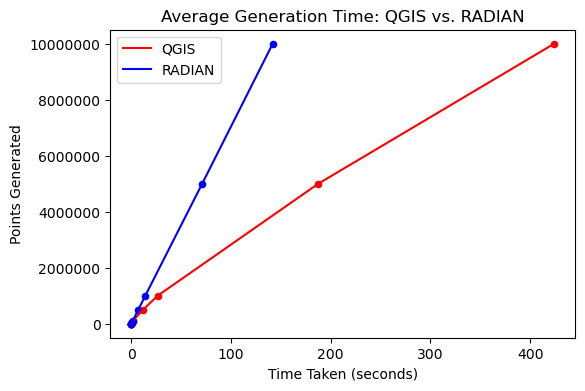

\begin{tabular}{rrrr}
\toprule
  points &   radian &     qgis &  percent\_diff \\
\midrule
     100 &   0.0160 &   0.0157 &         -1.91 \\
     500 &   0.0194 &   0.0162 &        -19.75 \\
    1000 &   0.0263 &   0.0226 &        -16.37 \\
    5000 &   0.0804 &   0.0610 &        -31.80 \\
   10000 &   0.1442 &   0.1112 &        -29.68 \\
   50000 &   0.6828 &   0.5434 &        -25.65 \\
  100000 &   1.3537 &   1.3648 &          0.81 \\
  500000 &   6.8642 &  11.7337 &         41.50 \\
 1000000 &  13.9235 &  26.3364 &         47.13 \\
 5000000 &  71.0024 & 187.4563 &         62.12 \\
10000000 & 141.7632 & 424.0863 &         66.57 \\
\bottomrule
\end{tabular}



C:\Users\Paddy\AppData\Local\Temp\ipykernel_28836\1592748315.py:201: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_mean.iloc[0:11,:].to_latex(index=False))


In [38]:
import random
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import random
import time

from shapely.geometry import box
from shapely.ops import triangulate
from shapely.ops import cascaded_union
from shapely.ops import unary_union

from scipy.stats import multivariate_normal

from sklearn.cluster import KMeans
from geovoronoi import voronoi_regions_from_coords, points_to_coords

import matplotlib.pyplot as plt

def poly_bb(polygon):
    minx, miny, maxx, maxy = polygon.total_bounds
    bbox = box(minx, miny, maxx, maxy, ccw=True)
    return gpd.GeoSeries(bbox)

def poly_bb_ratio(polygon):
    bb = poly_bb(polygon)
    return float(1/(polygon.area/bb.area))

def point_in_triangle(poly_tri):
    v1, v2, v3 = poly_tri.exterior.coords[0:3]
    v2_scaled = [v2[0] - v1[0], v2[1] - v1[1]]
    v3_scaled = [v3[0] - v1[0], v3[1] - v1[1]]
    
    s, t = random.uniform(0,1), random.uniform(0,1)
    if s+t > 1:
        s = 1 - s
        t = 1 - t
    two_weighted = [v2_scaled[0] * s, v2_scaled[1] * s]
    three_weighted = [v3_scaled[0] * t, v3_scaled[1] * t]

    new_point = np.add(np.add(two_weighted, three_weighted), [v1[0], v1[1]])
    
    return shapely.Point(new_point)

def point_in_bb(minx, miny, maxx, maxy):
    return shapely.Point([random.uniform(minx, maxx), random.uniform(miny, maxy)])

def uniform_pip(polygon, points):
    minx, miny, maxx, maxy = polygon.total_bounds
    
    points_list = gpd.GeoDataFrame(pd.DataFrame([point_in_bb(minx, miny, maxx, maxy) for i in range(round(points * poly_bb_ratio(polygon)))], columns=['geometry']), geometry='geometry', crs=polygon.crs)

    points_list = points_list.sjoin(polygon, predicate='within')
    if(len(points_list) > points):
        return points_list[0:points]
    return points_list

def kmeans_centroids(poly, num_points, num_cluster):
    source = uniform_pip(poly, num_points)
    feature_coords = np.array([[e.x, e.y] for e in source.geometry])
    kmeans = KMeans(num_cluster, n_init='auto')
    kmeans.fit(feature_coords)
    centroids = kmeans.cluster_centers_
    df = pd.DataFrame(centroids, columns=['x', 'y'])
    return gpd.GeoDataFrame([], geometry=gpd.points_from_xy(df.x, df.y), crs=source.crs)
     

def voronoi_gen(poly, vor_num):
    # Voronoi centroids are generated based on the specified generation type
    vor_centroids = kmeans_centroids(poly, 500, vor_num)

    # Setting crs to meter based projection
    gdf_proj = vor_centroids.set_crs(poly.crs)

    # Convert the boundary geometry into a union of the polygon
    boundary_shape = unary_union(poly.geometry)
    coords = points_to_coords(gdf_proj.geometry)

    region_polys, _ = voronoi_regions_from_coords(coords, boundary_shape)
    # Create GeoDataFrame of the Voronoi Polygons

    gdf_poly = gpd.GeoDataFrame(pd.DataFrame({'geometry': list(region_polys.values())}), geometry='geometry', crs=poly.crs)

    return gdf_poly

def dist_calc_poly(poly, tris):
    tris['dist_to_centre'] = 0
    p = poly.centroid
    for i, tri in enumerate(tris['geometry']):
        current = tri.centroid.distance(shapely.geometry.Point(p.x, p.y))
        tris.loc[i, 'dist_to_centre'] = current

    # Assign a class to each polygon based on the distance to centroid
    # This will produce five distinct regions centred around the given moving/original centroid

    max_dist, min_dist = max(tris['dist_to_centre']), min(tris['dist_to_centre'])
    dist_break = (max_dist - min_dist) / 5
    tris['class'] = 0
    tris = tris.sort_values(by='dist_to_centre')
    tris['class'] = pd.cut(tris['dist_to_centre'], [0, dist_break, dist_break*2, dist_break*3, dist_break*4, np.inf], labels=[1,2,3,4,5])

    return tris

def polys_to_tri(polys):
    poly_list = []
    for poly in polys:
        poly_list += triangulate(poly)

    return gpd.GeoDataFrame(pd.DataFrame(poly_list, columns=['geometry']), geometry='geometry') 

def points_in_tris(tris, points):
    points_list = []    
    for i in range(points):
        points_list.append(point_in_triangle(random_poly(tris)))
        
    return gpd.GeoDataFrame(pd.DataFrame(points_list, columns=['geometry']), geometry='geometry')

def class_dist(tris):
    cum_dist = []
    max_class = sum(tris['class'])
    for i in range(len(tris)):
        if i > 0:
            last_value = cum_dist[i-1]
        else:
            last_value = 0
        cum_dist.append(last_value + (tris['class'][i] / max_class))
    return cum_dist

def random_poly(polys):
    cum_dist = class_dist(polys)
    poly_index = [i for i in range(len(polys))]
    index = random.choices(poly_index, weights=list(polys['class']), k=1)    
    x = polys.loc[index, 'geometry'].reset_index(drop=True)
    return x[0]
    
def pip(dir):
    poly_source = gpd.read_file(dir)
    poly_source = poly_source.to_crs(epsg=3857)
    fig, axs = plt.subplots(1,2, figsize=(8, 5))

    fig.tight_layout()
    fig.suptitle(f"Points in polygon testing")

    start_time = time.time()

    poly_source_tri = gpd.GeoSeries(triangulate(poly_source.iloc[0][0]))
    poly_source_bb = poly_bb(poly_source)
    poly_source_bb_tri = gpd.GeoSeries(triangulate(poly_source_bb[0]))

    voronoi_polys = voronoi_gen(poly_source, 128)
    voronoi_tri = polys_to_tri(list(voronoi_polys['geometry']))

    voronoi_tri = dist_calc_poly(poly_source, voronoi_tri)
    voronoi_tri_points = points_in_tris(voronoi_tri, 500)

    end_time = time.time()

    for ax in axs:
        ax.axis("off")
        poly_source.plot(ax=ax, edgecolor='green', facecolor='none')
        poly_source_bb.plot(ax=ax, edgecolor='red', facecolor='none')
        
    #poly_source_bb_tri.plot(ax=axs[0], edgecolor='purple', facecolor='none')
    voronoi_polys.plot(ax=axs[0], edgecolor='red', cmap='Blues')
    voronoi_tri.plot(ax=axs[1], edgecolor='none', cmap='Blues', column='class')
    voronoi_tri_points.plot(ax=axs[1], color='red', markersize=5)

    plt.show()

    print("Number of triangles: ", len(voronoi_tri))
    print("Generation time: ", end_time - start_time)


def plot_radian_comparison():
    df = pd.read_csv("radianqgis_compare.csv")
    #df['difference'] = round(((df.qgis - df.radian)/df.qgis)*100, 2)

    df_mean = df.groupby('points', group_keys=False).mean().reset_index().drop(columns=['experiment'])
    df_mean['percent_diff'] = np.round(((df_mean['qgis'] - df_mean['radian'])/df_mean['qgis']) * 100, 2)
    
    y_qgis, y_radian = df_mean['qgis'], df_mean['radian']
    x = df_mean['points']

    fig, ax = plt.subplots(figsize=(6,4))

    df_mean.plot(ax=ax, x='qgis', y='points' ,color='red', label= 'QGIS')
    df_mean.plot(ax=ax, x='qgis', y='points' ,color='red', kind='scatter')
    df_mean.plot(ax=ax, x='radian', y='points',color='blue', label='RADIAN')
    df_mean.plot(ax=ax, x='radian', y='points',color='blue', kind='scatter')
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel('Time Taken (seconds)')
    ax.set_ylabel('Points Generated')
    #ax.set_ylim(bottom=0, top=120000)
    #ax.set_xlim(left=0, right=2)

    ax.set_title('Average Generation Time: QGIS vs. RADIAN')

    plt.show()

    print(df_mean.iloc[0:11,:].to_latex(index=False))

plot_radian_comparison()
#pip("scenarios/kildare/kildare.geojson")


Generation time:  0.2755732536315918
Total points generated: 100000
Points within polygon: 38344
Generation time (Bounding box):  1.3206815719604492


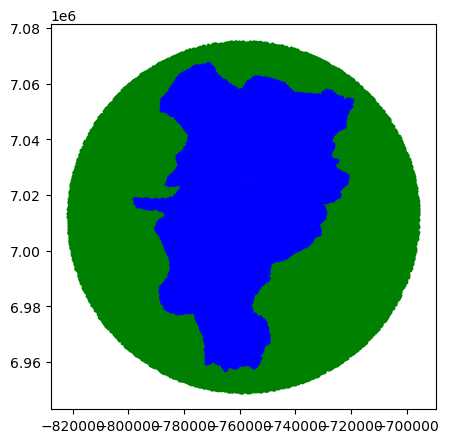

In [4]:
def polar_points(dir, points):
    poly_source = gpd.read_file(dir)
    poly_source = poly_source.to_crs(epsg=3857)
    
    start_time = time.time()
    
    minx, miny, maxx, maxy = poly_source.total_bounds
    poly_center_x, poly_center_y = poly_source.centroid.x[0], poly_source.centroid.y[0]

    diameter = (maxx - minx) * 0.8

    r, theta = [(np.sqrt(random.random()) * diameter) for i in range(points)], [(2*np.pi*random.random() * diameter) for i in range(points)]

    x = ((r * np.cos(theta)) + ((minx + maxx) / 2)) 
    y = ((r * np.sin(theta)) + ((miny + maxy)/2))

    df = pd.DataFrame(zip(x, y), columns=['x', 'y'])
    poly_points = gpd.GeoDataFrame([], geometry=gpd.points_from_xy(df.x, df.y), crs=poly_source.crs)
    poly_sjoin = poly_points.sjoin(poly_source, predicate='within')
    end_time = time.time()

    fig, ax = plt.subplots(figsize=(10,5))

    poly_source.plot(ax=ax, edgecolor='red', facecolor='none')
    poly_points.plot(ax=ax, color='green', markersize=3)
    poly_sjoin.plot(ax=ax, color='blue', markersize=3)

    print("Generation time: ", end_time - start_time)
    print(f"Total points generated: {len(poly_points)}\nPoints within polygon: {len(poly_sjoin)}")

    bb_time_start = time.time()
    bb_points = uniform_pip(poly_source, points)
    bb_time_end = time.time()

    print("Generation time (Bounding box): ", bb_time_end - bb_time_start)

polar_points("scenarios/kildare/kildare.geojson", 500)
